# Setting

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

In [ ]:
device = torch.device('cuda')
torch.set_default_device(device)

# Load Images


In [ ]:
imsize = (512, 512)

loader = transforms.Compose([
    transforms.Resize(imsize),       # 이미지 크기 조정
    transforms.ToTensor()            # PIL 이미지를 텐서로 변환 (H * W * C -> C * H * W), [0 ~ 255] -> [0 ~ 1]
])

def image_loader(image_name):
  image = Image.open(image_name)
  # 네트워크의 입력 차원에 맞추기 위해 필요한 가짜 배치 차원
  image = loader(image).unsqueeze(0)          # 이미지 크기 조정, 텐서로 변환
  return image.to(device, torch.float)        # 텐서로 변환한 이미지를 device로 이동

style_img = image_loader('/content/img/style_1.jpg')
content_img = image_loader('/content/img/content_1.jpg')

In [ ]:
unloader = transforms.ToPILImage()       # 텐서를 다시 PIL 이미지로 변환 (C * H * W -> H * W * C), [0 ~ 1] -> [0 ~ 255]

plt.ion()      # 그래프 초기 설정 (대화형 모드를 활성화시키는 명령어)

def imshow(tensor):
  image = tensor.cpu().clone()     # 텐서를 복제함. 원본은 변경하지 않음 (텐서 상태 유지)
  image = image.squeeze(0)         # 가짜 배치 차원 제거
  image = unloader(image)          # 텐서를 PIL 이미지로 변환
  plt.imshow(image)
  plt.pause(0.001)     # 잠시 멈춤

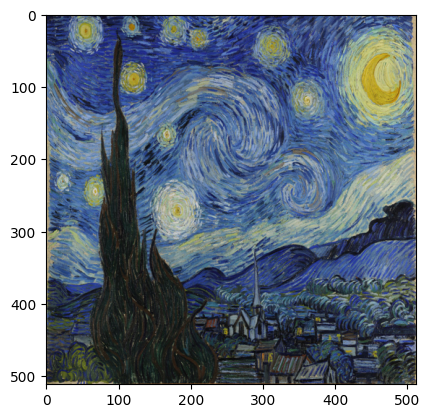

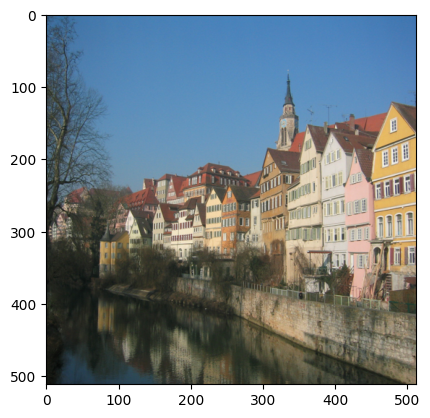

In [ ]:
plt.figure()
imshow(style_img)

plt.figure()
imshow(content_img)

# Loss Function

In [ ]:
class ContentLoss(nn.Module):         # nn.Module 받아서 기본 모듈 클래스 기능 사용

  def __init__(self, target):         # target: 목표로 하는 텐서
    super(ContentLoss, self).__init__()
    # detach 메서드를 통해 target 값이 고정되어 손실 계산에만 사용되고, 역전파 과정에서 사용되지 않도록 함.
    self.target = target.detach()

  def forward(self, input):       # 입력 텐서 input을 받아 loss 계산
    self.loss = F.mse_loss(input, self.target)    # input과 target 사이의 MSE Loss 계산
    # 입력 텐서 그대로 다음 계층의 입력으로 반환, loss는 내부적으로 저장됨.
    return input

In [ ]:
def gram_matrix(input):         # Gram 행렬로 변환하는 함수
  n, c, h, w = input.size()
  # n: 배치 크기
  # c: 채널 수
  # h, w: height, width

  features = input.view(n * c, h * w)    # input을 (n * c, h * w) 크기로 변경
  # n과 c가 하나의 차원, h와 w가 또 다른 차원으로 합쳐짐

  # features와 transpose matrix의 행렬 곱 (gram product) 계산
  G = torch.mm(features, features.t())

  # G (Gram 행렬) 값을 (n * c * h * w) 로 나누어 정규화(normalization)
  return G.div(n * c * h * w)

In [ ]:
class StyleLoss(nn.Module):           # ContentLOss와 비슷함. gram_matrix 과정이 추가됨

  def __init__(self, target_feature):
    super(StyleLoss, self).__init__()
    self.target = gram_matrix(target_feature).detach()

  def forward(self, input):
    G = gram_matrix(input)
    # input과 target 모두 gram_matrix에 넣어 Gram 행렬로 변환 후 loss 값을 계산
    self.loss = F.mse_loss(G, self.target)
    return input

# Model

In [ ]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()
# weights=VGG19_Weights.DEFAULT: 사전 학습된 가중치를 사용하도록 지정
# VGG19 모델은 features와 classifier 부분으로 구성됨
# features: Conv 레이어들로 구성되어 이미지의 특징을 추출
# classifier: fully connected layers
# .features: Conv로 구성된 부분만을 선택
# .eval(): 모델을 evaluation mode로 설정. dropout과 batch normalizaion이 비활성화됨

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:08<00:00, 67.0MB/s]


In [ ]:
mean_rgb = torch.tensor([0.485, 0.456, 0.406])
std_rgb = torch.tensor([0.229, 0.224, 0.225])    # 각 채널을 정규화 된 이미지로 훈련

class Normalization(nn.Module):

  def __init__(self, mean, std):
    super(Normalization, self).__init__()
    self.mean = torch.tensor(mean).view(-1, 1, 1)    # mean 값을 텐서로 변환하고, (채널, 1, 1) 형태로 변환
    self.std = torch.tensor(std).view(-1, 1, 1)      # std 값을 텐서로 변환하고, (채널, 1, 1) 형태로 변환

  def forward(self, img):      # img를 입력받아 정규화된 이미지를 반환
    return (img - self.mean) / self.std     # 각 채널의 픽셀 값이 정규화됨

In [ ]:
content_layers_default = ['conv_4']       # 논문 [Fig1]의 (d) layer
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers = content_layers_default,        # content loss를 계산할 레이어
                               style_layers = style_layers_default):           # style loss를 계산할 레이어

  normalization = Normalization(normalization_mean, normalization_std)

  content_losses = []         # content loss 저장
  style_losses = []           # style loss 저장

  model = nn.Sequential(normalization)     # 모델 구성 시작

  i = 0
  for layer in cnn.children():         # VGG19의 모든 레이어 순회, 레이어 타입에 따라 이름 지정
    if isinstance(layer, nn.Conv2d):
      i += 1
      name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
      name = 'relu_{}'.format(i)
      layer = nn.ReLU(inplace = False)      # 레이어의 출력 수정하지 않음
    elif isinstance(layer, nn.MaxPool2d):
      name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
      name = 'bn_{}'.format(i)
    else:
      raise RuntimeError('Unrecognized Layer : {}'.format(layer.__class__.__name__))

    model.add_module(name, layer)      # 레이어를 model에 추가

    if name in content_layers:         # if name in ['conv_4']
      target = model(content_img).detach()     # 현재 레이어의 출력을 target으로 설정
      content_loss = ContentLoss(target)
      model.add_module('content_loss_{}'.format(i), content_loss)
      content_losses.append(content_loss)

    if name in style_layers:           # if name in ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
      target_feature = model(style_img).detach()       # 현재 레이어의 출력을 target_feature로 설정
      style_loss = StyleLoss(target_feature)
      model.add_module('style_loss_{}'.format(i), style_loss)
      style_losses.append(style_loss)

  # 불필요한 레이어 제거
  for i in range(len(model) - 1, -1, -1):
    if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
      break

  model = model[:(i + 1)]

  # 모델과 loss 반환
  return model, style_losses, content_losses

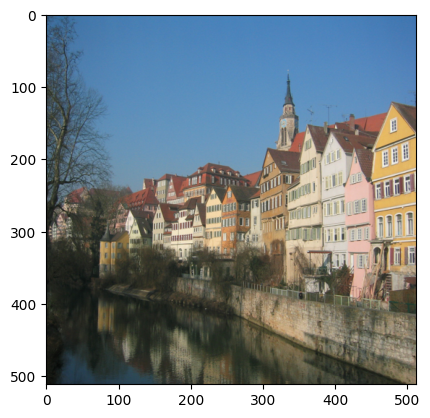

In [ ]:
input_img = content_img.clone()

plt.figure()
imshow(input_img)

# Gradient Descent

In [ ]:
# input_img를 최적화하는 데 사용할 optimizer를 생성
def get_input_optimizer(input_img):
  optimizer = optim.LBFGS([input_img])     # optimizer로 LBFGS 사용
  return optimizer

# Style Transfer

In [ ]:
def style_transfer(cnn, normalization_mean, normalization_std,
                   content_img, style_img, input_img, num_steps = 300,
                   style_weight = 1000000, content_weight = 1):
  # input_img: 초기 입력 이미지 텐서. NST 결과가 이 이미지에서 시작하여 업데이트됨
  # num_steps: 최적화 단계의 수
  # style_weight: style loss에 곱할 가중치
  # content_wegith: content loss에 곱할 가중치

  print('Building the Style Transfer Model...')

  model, style_losses, content_losses = get_style_model_and_losses(cnn,
      normalization_mean, normalization_std, style_img, content_img)

  input_img.requires_grad_(True)    # input_img가 최적화 동안 업데이트됨

  model.eval()                   # 평가 모드 설정 (dropout, batch normalization 비활성화)
  model.requires_grad_(False)    # 모델의 파라미터들이 업데이트되지 않음

  optimizer = get_input_optimizer(input_img)     # optimizer 생성

  print('Optimizing...')

  run = [0]          # 실행 횟수
  while run[0] <= num_steps:

    def closure():                 # 손실 계산 및 역전파 수행 함수
      with torch.no_grad():
        input_img.clamp_(0, 1)     # input_img의 픽셀 값을 0과 1 사이로 clamping

      optimizer.zero_grad()        # 이전 단계 기울기 초기화
      model(input_img)             # input_img를 model에 전달 (loss값 계산)
      style_score = 0
      content_score = 0

      # loss 값 누적
      for sl in style_losses:
        style_score += sl.loss
      for cl in content_losses:
        content_score += cl.loss

      # loss값에 각각 가중치 곱함
      style_score *= style_weight
      content_score *= content_weight

      loss = style_score + content_score      # total loss
      loss.backward()                         # back propagation

      run[0] += 1
      if run[0] % 50 == 0:
        print('run {}'.format(run))
        print('Style Loss : {:4f} Content Loss : {:4f}'.format(style_score.item(), content_score.item()))
        print()

      return style_score + content_score

    optimizer.step(closure)       # 최적화 단계 한 번 수행
  with torch.no_grad():
    input_img.clamp_(0, 1)        # 최종 이미지 0과 1 사이로 clamping

  return input_img                # 최종 이미지 반환

# Execute

Building the Style Transfer Model...


/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Optimizing...
run [50]
Style Loss : 88.059250 Content Loss : 32.958992

run [100]
Style Loss : 31.841501 Content Loss : 28.899609

run [150]
Style Loss : 13.092192 Content Loss : 23.645061

run [200]
Style Loss : 6.632504 Content Loss : 19.297808

run [250]
Style Loss : 4.492630 Content Loss : 16.434317

run [300]
Style Loss : 3.414857 Content Loss : 14.423376



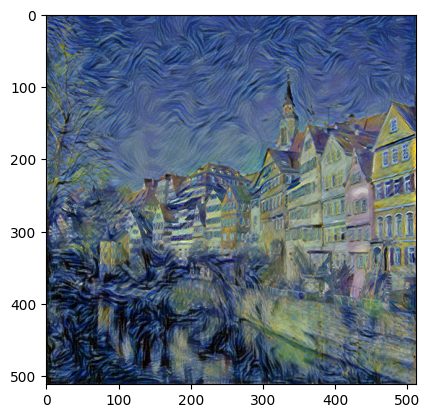

In [ ]:
# 실행
output = style_transfer(cnn, mean_rgb, std_rgb,
                        content_img, style_img, input_img)

plt.figure()
imshow(output)

plt.ioff()
plt.show()